In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tikzplotlib

import math

# PV-$\alpha$

In this model, voters are partitioned in two groups: Voting voters $V_v$ who cast a vote from $\{-1, +1\}$ and delegating voters $V_d$ who delegate their vote to some member of $V_v$.

### Parameters

External :
* $|V_v|$ and $|V_d|$

Internal :
* None

### Discussion

We assume uniformity assumption, so voters from $V_v$ vote $+1$ with probability $1/2$ and $-1$ with probability $1/2$. Voters from $V_v$ delegate to any $v \in V_v$ with probability $1/|V_v|$.

Extreme cases : 
* $|V_v| = 1$ : Dictatorship
* $|V_d| = 0$ : Direct democracy


We assume that all voters have weight 1

In [2]:
def create_bill_PVa(n_v, n_d):
    '''
    This function create a delegation partition for PV-\alpha, 
    and return the vote of voters in V_v between 0 and 1, 
    and the delegations of voters in V_d.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_v = np.random.randint(2, size=(n_v), dtype=int)
    v_d = np.random.randint(n_v, size=(n_d), dtype=int)
    return v_v, v_d

def test_critical_PVa(n_v, n_d):
    '''
    This function takes as input the number of proxies and delegating voters in PV-\alpha setting,
    create a delegation partition, and count the number of voters in each group that are critical.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    n = n_v + n_d
    v_v, v_d = create_bill_PVa(n_v, n_d)
    
    # We compute the voting weight of every voters of V_v
    w = np.ones(n_v)
    for x in v_d:
        w[x] += 1
        

    # We compute the result of the election
    vote_for = np.dot(v_v, w)*2 - n
    if vote_for >= 0:
        sign = 1
    elif vote_for < 0:
        sign = 0
        
    
    # For every voter in V_v, we see if they are critical in this situation
    p_v = 0
    for i in range(n_v):
        if v_v[i] == sign:
            copy_v = v_v.copy()
            copy_v[i] = 1 - sign
            vote_for_copy = np.dot(copy_v, w)*2 - n
            if (vote_for_copy >= 0 and sign == 0) or (vote_for_copy < 0 and sign == 1):
                p_v += 1
    
    # For every voter in V_d, we see if they are critical in this situation
    p_d = 0
    if vote_for >= -2 and vote_for < 2:
        for x in v_d:
            if v_v[x] == sign:
                p_d += 1
                
    # Just to avoid dividing by 0
    if n_v == 0:
        n_v = 1
    if n_d == 0:
        n_d = 1
                
    return p_v/n_v, p_d/n_d


def expe_PVA(n_v, n_d, n_trys):
    '''
    This function takes as input the number of proxies and delegating voters in PV-\alpha setting,
    iterates over n_trys delegations partitions and compute the overall criticality of voters in V_v and V_d.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    p_v = np.zeros(n_trys)
    p_d = np.zeros(n_trys)
    
    for i in range(n_trys):
        p_v_i, p_d_i = test_critical_PVa(n_v, n_d)
        p_v[i] = p_v_i
        p_d[i] = p_d_i
    
    return p_v, p_d
        

        
    
    

**Experiment for the paper**

Here we have $100$ voters and we look at different values of $|V_v|$ from 0 to 100.

In [41]:
n_voters = 100
tab_n = [1,2,3,4] + [n*5 for n in range(1, n_voters//5+1)]
len_tab = len(tab_n)
tab_res = np.zeros((2, len_tab))

for i, n in tqdm(enumerate(tab_n)):
    p_v, p_d = expe_PVA(n, n_voters-n, 100000)
    tab_res[0, i] = p_v.mean()
    tab_res[1, i] = p_d.mean()

24it [07:54, 19.78s/it]


Text(0, 0.5, 'Probability of being critical')

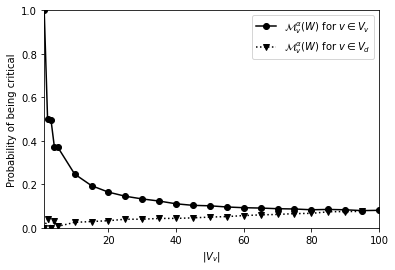

In [4]:
tab_res
plt.plot([n for n in tab_n], tab_res[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
# plt.xticks(tab_n[::], tab_n[::])
#plt.title(r'$%i$ voters'%n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel(r'Probability of being critical')

# PV-$\beta$

This model is very similar, but delegating voters have the choice to vote themselves or delegate to some voter in $V_v$.

### Parameters

External :

* $|V_v|$ and $|V_d|$

Internal :

* $p_d$ probability to delegate for voters in $V_d$.

### Discussion

Extreme case :

* $p_d = 0$ : Direct democracy
* $p_d = 1$ : PV-$\alpha$

We assume that all voters have weights 1

In [5]:
def create_bill_PVb(n_v, n_d, proba_d):
    '''
    This function create a delegation partition for PV-\beta, 
    and return the vote of voters in V_v between 0 and 1, 
    For v_d it select with v_d_d if they delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_d_1 if they vote directly, v_d_2 if they delegate.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_v = np.random.randint(2, size=(n_v), dtype=int)
    v_d_d = np.zeros(n_d, dtype=int)
    v_d_d[::] = proba_d <= np.random.rand(n_d)
    v_d_1 = np.random.randint(2, size=(n_d), dtype=int)
    v_d_2 = np.random.randint(n_v, size=(n_d), dtype=int)
    return v_v, (v_d_d, v_d_1, v_d_2)

def test_critical_PVb(n_v, n_d, proba_d):
    '''
    This function takes as input the number of proxies and delegating voters, and the probability to delegate
    in PV-\beta setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    n = n_v + n_d
    
    # create a delegation partition
    v_v, (v_d_d, v_d_1, v_d_2) = create_bill_PVb(n_v, n_d, proba_d)
    
    # We add two fake proxies for the delegating voters that vote directly.
    votes = np.concatenate([v_v, [1], [0]])
    w = np.ones(n_v+2)
    w[-1] = 0
    w[-2] = 0
    
    # We compute the weights of the proxies and the number of delegating voters that vote for and against.
    for i in range(n_d):
        if v_d_d[i]:
            w[-1-v_d_1[i]] += 1
        else:
            w[v_d_2[i]] += 1
        
    # We compute the results of the rule
    vote_for = np.dot(votes, w)*2 - n
    if vote_for >= 0:
        sign = 1
    elif vote_for < 0:
        sign = 0
        
    # We compute the number of voters in V_v that are critical
    p_v = 0
    for i in range(n_v):
        if v_v[i] == sign:
            copy_v = votes.copy()
            copy_v[i] = 1 - sign
            vote_for_copy = np.dot(copy_v, w)*2 - n
            if (vote_for_copy >= 0 and sign == 0) or (vote_for_copy < 0 and sign == 1):
                p_v += 1
    
    # We compute the number of voters in V_d that are critical
    p_d = 0
    if vote_for >= -2 and vote_for < 2:
        for i in range(n_d):
            if v_d_d[i]:
                if v_d_1[i] == sign:
                    p_d += 1
            elif v_v[v_d_2[i]] == sign:
                p_d += 1
         
    # To avoid dividing by 0
    if n_v == 0:
        n_v = 1
    if n_d == 0:
        n_d = 1
                
    return p_v/n_v, p_d/n_d


def expe_PVb(n_v, n_d, n_trys, proba_d):
    '''
    This function takes as input the number of proxies and delegating voters in PV-\alpha setting,
    iterates over n_trys delegations partitions and compute the overall criticality of voters in V_v and V_d.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    p_v = 0
    p_d = 0
    
    for _ in range(n_trys):
        p_v_i, p_d_i = test_critical_PVb(n_v, n_d, proba_d)
        p_v += p_v_i
        p_d += p_d_i
    
    return p_v/n_trys, p_d/n_trys
        

        
    

**Experiment for the paper**

Here we have $100$ voters and we look at different values of $|V_v|$ from 0 to 100.

In [39]:
n_voters = 100
tab_n = [1,2,3,4] + [n*5 for n in range(1, n_voters//5+1)]
len_tab = len(tab_n)
tab_resb = np.zeros((2, len_tab))

for i, n in tqdm(enumerate(tab_n)):
    p_v, p_d = expe_PVb(n, n_voters-n, 100000, 0.5)
    tab_resb[0, i] = p_v
    tab_resb[1, i] = p_d

24it [07:53, 19.73s/it]


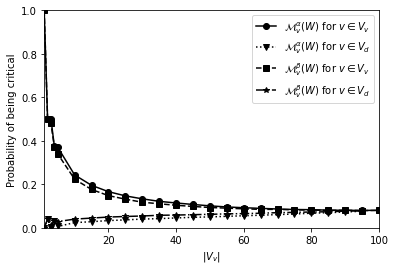

In [44]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

tab_res
plt.plot([n for n in tab_n], tab_res[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
#plt.title(r'$%i$ voters'%n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel('Probability of being critical')
tab_resb
plt.plot([n for n in tab_n], tab_resb[0], 's', linestyle = 'dashed', label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_resb[1][:-1], '*', linestyle = '-.' ,label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
#plt.xlim(1,n_voters)
#plt.title("%i voters"%n_voters)
#plt.xlabel("Number of voting voters")
#plt.ylim(0,1)
#plt.ylabel("Power")
tikzplotlib.save("criticality_pv.tex")
plt.savefig("criticality_pv.png")
plt.show()

**Experiment for the paper**

Here we have $100$ voters and we look at different values of $|V_v| \in [20,50]$ and $p_d$ going from $0$ to $1$. 

In [53]:
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_resc = np.zeros((2, len_tab))

for i, proba_d in tqdm(enumerate(tab_n)):
    p_v, p_d = expe_PVb(20, 80, 100000, proba_d)
    tab_resc[0, i] = p_v
    tab_resc[1, i] = p_d
    
    
tab_resc2 = np.zeros((2, len_tab))

for i, proba_d in tqdm(enumerate(tab_n)):
    p_v, p_d = expe_PVb(50, 50, 100000, proba_d)
    tab_resc2[0, i] = p_v
    tab_resc2[1, i] = p_d


11it [04:03, 22.10s/it]


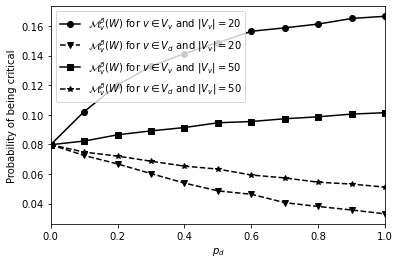

In [55]:
plt.plot([n for n in tab_n], tab_resc[0], 'o', ls = '-',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$ and $|V_v| = 20$', color="black")
plt.plot([n for n in tab_n], tab_resc[1], 'v', ls = '--',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$ and $|V_v| = 20$', color="black")
plt.plot([n for n in tab_n], tab_resc2[0], 's', ls = '-',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$ and $|V_v| = 50$', color="black")
plt.plot([n for n in tab_n], tab_resc2[1], '*', ls = '--',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$ and $|V_v| = 50$', color="black")
plt.legend()
plt.xlim(0,1)
#plt.title("20 voters (5 representants)")
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
tikzplotlib.save("criticality_pv_pd_2.tex")
plt.savefig("criticality_pv_pd_2.png")
plt.show()

# LD

In this last model, every voter can delegate to every other voter, or vote themselves. This can lead to delegation chains, or delegation cycles. The probability to delegate is $p_d$ and the probability to delegate to a particular voter is $p_d \times \frac{1}{|V| -1}$. The probability to answer $+1$ or $-1$ is $\frac{1-p_d}{2}$.

### Parameters

External :

* $|V_v|$ and $|V_d|$

Internal :

* p_d probability to delegate for voters in $V_d$.

### Discussion

Extreme case :

* $p_d = 0$ : Direct democracy
* $p_d = 1$ : Nobody vote

We assume here that voters have different weights.

In [13]:
def create_bill_LD(n, proba_d):
    '''
    This function create a delegation partition for LD,  
    It select with v_d if voters delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_1 if they vote directly, v_2 if they delegate and we take care of avoiding self delegations.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_d = np.zeros(n, dtype=int)
    v_d[::] = proba_d <= np.random.rand(n)
    v_1 = np.random.randint(2, size=(n), dtype=int)
    v_2 = np.random.randint(n, size=(n), dtype=int)
    for i in range(n):
        while v_2[i] == i:
            v_2[i] = np.random.randint(n)
                
    return v_d, v_1, v_2

In [27]:
def compute_result_weighted(v_d, v_1, v_2, weights):
    '''
    This function takes as input a delegation instance, and weights of voters, and compute the results of the election in
    this delegation instance
    '''
    n = len(v_d)
    
    # V is the vector of final vote (+1, -1 or 0 if the voter is abstaining)
    v = np.zeros(n)
    
    # We push in q all the delegating voters
    q = []
        
    for i in range(n):
        if v_d[i]:
            v[i] = 2*v_1[i]-1
        else:
            q.append(i)
            
            
    # We propagate the vote of direct voters to the voters delegating to them until we've seen all the voters
    # The idea is similar to a DFS, but in a tree.
    abst = []
    while q != []:
        x = q.pop()
        if x in abst or v[x] != 0:
            continue
        seen = []
        while x not in seen and x not in abst and v[x] == 0:
            seen.append(x)
            x = v_2[x]
        
        if x in seen or x in abst:
            for y in seen:
                if y not in abst:
                    abst.append(y)
        else:
            r = v[x]
            for y in seen:
                v[y] = r
                
    # We compute the results
    r = v.dot(weights)
    
    return r >=0, v

def test_critical_LD_weighted(n, proba_d, weights):
    '''
    This function takes as input the number of voters, the probability to delegate and the weights
    in the LD setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that we are in a WVG with q = 0.5. We also assume that weights are natural number between 1 and 9.
    '''
    v_d, v_1, v_2 = create_bill_LD(n, proba_d)
    res, v = compute_result_weighted(v_d, v_1, v_2, weights)
    
    power = np.zeros(10)
    
    # We look for every voter that agree with the result if the result would change if this voter changes his vote.
    for i in range(n):
        res2 = res
        if v[i] != -1 and res == 1:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 0
            res2, _ = compute_result_weighted(v_d_copy, v_1_copy, v_2, weights)
            
        elif v[i] != 1 and res == 0:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 1
            res2, _ = compute_result_weighted(v_d_copy, v_1_copy, v_2, weights)
        if res != res2:
            power[weights[i]-1] += 1
    
    
    return power
            
    


**Experiment of the paper**

We now conduct experiments to see the impact of the probability of delegating on the criticality of voters with differents weights ($1,2,5$) in a WVG with 50 voters of weight 1, 30 of weight 2 and 20 voters of weight 5.

In [49]:
def expe_LD_weightedv(n, n_trys, proba_d):
    """
    
    This function takes as input the number of voters, the probability to delegate and the number of delegation
    instances tested. We construct a WVG with 50 voters of weight 1, 30 voters of weight 2 and 20 voters of weight 5.
    """
    p_v = np.zeros(10)
    c_v = np.zeros(10)
    
    for _ in tqdm(range(n_trys)):
        weights = [1]*50 + [2]*30 + [5]*20
        res_i = test_critical_LD_weighted(n, proba_d, weights)
        for w in weights:
            c_v[w-1] += 1
        for i in range(10):
            p_v[i] += res_i[i]
    
    return p_v/c_v



In [50]:
tab_n = np.linspace(0,0.9,10)

len_tab = len(tab_n)
tab_res = np.zeros((3,len_tab))

for i, p_d in (enumerate(tab_n)):
    p_v = expe_LD_weightedv(100, 10000, p_d)
    tab_res[0][i] = p_v[0]
    tab_res[1][i] = p_v[1]
    tab_res[2][i] = p_v[4]

100%|██████████| 10000/10000 [00:49<00:00, 202.49it/s]
C:\Users\Theo Delemazure\env\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
100%|██████████| 10000/10000 [12:19<00:00, 13.52it/s]  


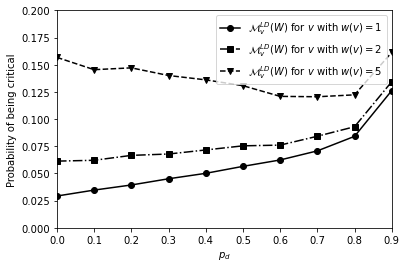

In [52]:
tab_res
plt.plot([n for n in tab_n], tab_res[0], '-o', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=1$', color="black")
plt.plot([n for n in tab_n], tab_res[1], '-.s', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=2$', color="black")
plt.plot([n for n in tab_n], tab_res[2], '--v', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=5$', color="black")

plt.legend()
plt.xlim(0,0.9)
plt.ylim(0,0.2)
#plt.title("10 voters")
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
tikzplotlib.save("criticality_ld.tex")
plt.savefig("criticality_ld.png")
plt.show()